## 2. Histogram-based Outlier Score (HBOS)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()

,0,1,2,3,4,5
0,2.396090,2.092611,2.073392,1.988262,1.953473,2.450997
1,1.631040,1.746182,1.898050,2.380148,1.967332,1.858916
2,1.824683,2.131412,2.028829,1.703454,2.502966,2.119108
3,2.106098,2.165173,2.340826,2.170109,1.749139,1.678661
4,1.829647,1.775596,1.829438,2.054768,1.577190,1.594549


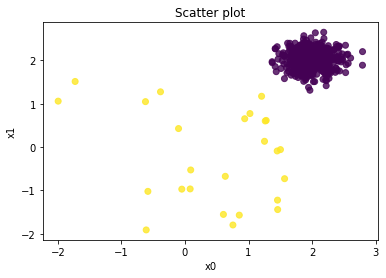

In [3]:
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Step 1: Build the model

In [4]:
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins,contamination=0.05)
hbos.fit(X_train)

# Training data
y_train_scores = hbos.decision_function(X_train)
y_train_pred = hbos.predict(X_train)

# Test data
y_test_scores = hbos.decision_function(X_test)
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , hbos.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

The threshold for the defined contamination rate: 5.563712646460526
The training data: {0: 475, 1: 25}
The training data: {0: 474, 1: 26}


### Step 2: Determine the threshold

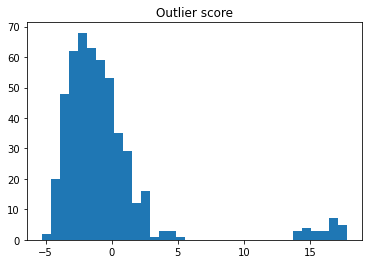

In [5]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

### Step 3: Descriptive statistics

In [6]:
threshold = hbos.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-1.28
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,16.02


In [7]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,474,94.8,2.02,2.01,2.01,1.99,2.01,2.00,-1.05
1,Outlier,26,5.2,0.06,-0.43,-0.12,0.02,0.02,0.18,16.65


In [8]:
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_train,y_train_scores,threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


In [9]:
confusion_matrix(y_test,y_test_scores,threshold)

Pred,0,1
Actual,,
0.0,474,1
1.0,0,25


### Step 4: Averages

In [10]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.hbos import HBOS

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of binning 
k_list = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins=n_bins)
    hbos.fit(X_train_norm)
    # Store the results in each column:
    train_scores[:, i] = hbos.decision_function(X_train_norm) 
    test_scores[:, i] = hbos.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

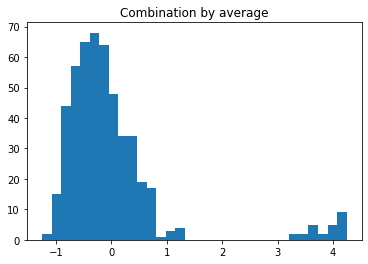

In [11]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [12]:
descriptive_stat_threshold(X_train,y_train_by_average, 1.4)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.20
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,3.86


In [13]:
descriptive_stat_threshold(X_test,y_test_by_average, 1.4)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,472,94.4,2.02,2.01,2.01,1.99,2.01,2.00,-0.15
1,Outlier,28,5.6,0.19,-0.27,0.04,0.18,0.14,0.33,3.73
